## Sequential model for weather forecasting
In this project we explore the using rnn, rnn with gru, seq2seq, seq2seq with attention, and transformer for weather forecasting.

## 0. import packages

In [44]:
import pickle, os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [45]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda


## 1. data preparation

In [46]:
data_2015 = pd.read_csv('data/2015.csv')
data_2016 = pd.read_csv('data/2016.csv')
data_2017 = pd.read_csv('data/2017.csv')
data_2018 = pd.read_csv('data/2018.csv')
data_2019 = pd.read_csv('data/2019.csv')
data_2020 = pd.read_csv('data/2020.csv')
data_2021 = pd.read_csv('data/2021.csv')
data_2022 = pd.read_csv('data/2022.csv')

In [47]:
#load date to train, valid and test
train_df = pd.concat([data_2015, data_2016, data_2017, data_2018, data_2019], axis=0, ignore_index=True)
valid_df = pd.concat([data_2020, data_2021], axis=0, ignore_index=True)
test_df = data_2022

In [48]:
#chec the date in df which have more than 3 missising
flab = ['Temp Flag', 'Rel Hum Flag', 'Dew Point Temp Flag', 'Precip. Amount Flag', 'Stn Press Flag', 'Wind Spd Flag']
print("----------------------tain--------------------------")
date_t = set()
for i in flab:
  count1 = train_df[train_df[i] == 'M'].groupby(['Year', 'Month', 'Day'])[i].count()
  count1 = count1[count1 > 3]
  for j in count1.keys():
    date_t.add(j)
print(date_t)
print("----------------------vali--------------------------")
date_v = set()
for i in flab:
  count1 = valid_df[valid_df[i] == 'M'].groupby(['Year', 'Month', 'Day'])[i].count()
  count1 = count1[count1 > 3]
  for j in count1.keys():
    date_v.add(j)
print(date_v)
print("----------------------test--------------------------")
date_s = set()
for i in flab:
  count1 = test_df[test_df[i] == 'M'].groupby(['Year', 'Month', 'Day'])[i].count()
  count1 = count1[count1 > 3]
  for j in count1.keys():
    date_s.add(j)
print(date_s)

----------------------tain--------------------------
{(2019, 6, 5), (2019, 6, 2), (2019, 5, 24), (2015, 12, 10), (2015, 4, 6), (2015, 12, 13), (2015, 12, 7), (2015, 11, 5), (2019, 6, 1), (2019, 6, 4), (2019, 6, 19), (2019, 5, 17), (2015, 12, 6), (2015, 12, 12), (2019, 5, 23), (2015, 12, 9), (2015, 11, 4), (2019, 6, 3), (2019, 6, 18), (2016, 12, 19), (2015, 12, 14)}
----------------------vali--------------------------
{(2021, 7, 21), (2020, 1, 14), (2021, 7, 30), (2021, 7, 20), (2021, 2, 9)}
----------------------test--------------------------
{(2022, 5, 13), (2022, 7, 10), (2022, 7, 13), (2022, 5, 28), (2022, 7, 19), (2022, 5, 22), (2022, 5, 25), (2022, 5, 31), (2022, 5, 12), (2022, 7, 9), (2022, 5, 9), (2022, 7, 6), (2022, 5, 21), (2022, 7, 12), (2022, 5, 24), (2022, 7, 21), (2022, 5, 27), (2022, 7, 18), (2022, 5, 30), (2022, 7, 5), (2022, 5, 11), (2022, 7, 8), (2022, 7, 14), (2022, 5, 20), (2022, 5, 26), (2022, 5, 23), (2022, 7, 20), (2022, 5, 29), (2022, 5, 10), (2022, 7, 7)}


In [49]:
#remove the day which have 3 more missing data in train datafram
for i in date_t:
  train_df = train_df[~((train_df['Year'] == i[0]) & (train_df['Month'] == i[1]) & (train_df['Day'] == i[2]))]
train_df.dropna(how='all')
train_df = train_df.reset_index(drop=True)
#remove the day which have 3 more missing data in valid datafram
for i in date_v:
  valid_df = valid_df[~((valid_df['Year'] == i[0]) & (valid_df['Month'] == i[1]) & (valid_df['Day'] == i[2]))]
valid_df.dropna(how='all')
valid_df = valid_df.reset_index(drop=True)
#remove the day which have 3 more missing data in test datafram
for i in date_s:
  test_df = test_df[~((test_df['Year'] == i[0]) & (test_df['Month'] == i[1]) & (test_df['Day'] == i[2]))]
test_df.dropna(how='all')
test_df = test_df.reset_index(drop=True)

In [50]:
#replace the missing data with the average of last and next hour
flab = ['Temp Flag', 'Dew Point Temp Flag', 'Rel Hum Flag', 'Precip. Amount Flag', 'Wind Spd Flag', 'Stn Press Flag']
vlab = ['Temp (°C)', "Dew Point Temp (°C)", "Rel Hum (%)", "Precip. Amount (mm)", "Wind Spd (km/h)", "Stn Press (kPa)"]
idx = 0
for i in flab:
  rows = train_df.loc[train_df[i] == 'M']
  for index, row in rows.iterrows():
    train_df.loc[index, vlab[idx]] = (
            ((train_df.loc[index - 1, vlab[idx]]) + train_df.loc[index + 1, vlab[idx]]) / 2)
  idx += 1
#replace the missing data in valid set
idx = 0
for i in flab:
  rows = valid_df.loc[valid_df[i] == 'M']
  for index, row in rows.iterrows():
    valid_df.loc[index, vlab[idx]] = (
            ((valid_df.loc[index - 1, vlab[idx]]) + valid_df.loc[index + 1, vlab[idx]]) / 2)
  idx += 1
#replace the missing data in test set
idx = 0
for i in flab:
  rows = test_df.loc[test_df[i] == 'M']
  for index, row in rows.iterrows():
    test_df.loc[index, vlab[idx]] = (
            ((test_df.loc[index - 1, vlab[idx]]) + test_df.loc[index + 1, vlab[idx]]) / 2)
  idx += 1

In [51]:
# chose the train data that need to used
labx = ["Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Precip. Amount (mm)", "Wind Spd (km/h)", "Stn Press (kPa)"]
temp = pd.DataFrame(columns=labx)
for j in labx:
  temp[j] = train_df[j]
train_data = temp
# chose the valid data that need to used
temp = pd.DataFrame(columns=labx)
for j in labx:
  temp[j] = valid_df[j]
valid_data = temp
# chose the test data that need to used
temp = pd.DataFrame(columns=labx)
for j in labx:
  temp[j] = test_df[j]
test_data = temp

# drop the row that contain None
train_data = train_data.dropna()
valid_data = valid_data.dropna()
test_data = test_data.dropna()

## 2. Data Summary

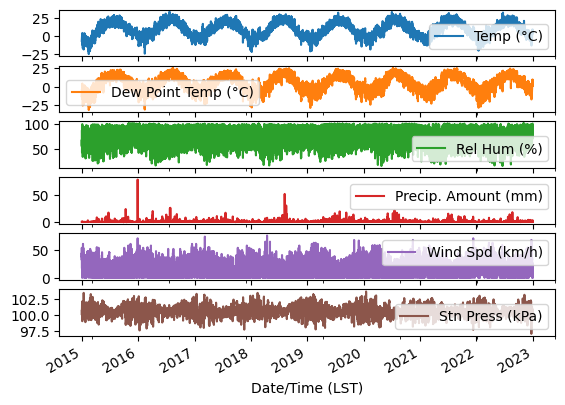

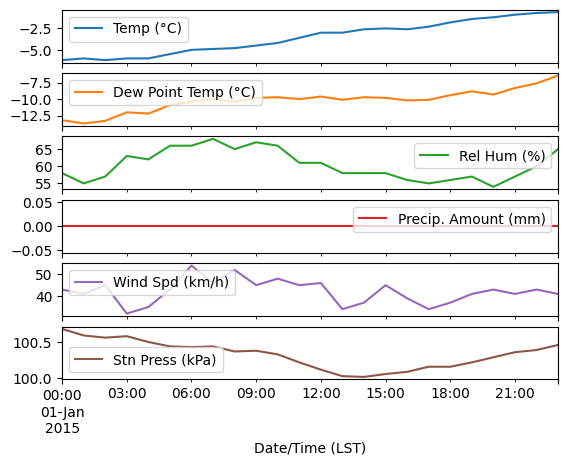

In [52]:
df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=True)
date_time = df['Date/Time (LST)']
date_time = pd.to_datetime(date_time, format='%Y/%m/%d %H:%M')
plot_cols = ["Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Precip. Amount (mm)", "Wind Spd (km/h)", "Stn Press (kPa)"]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:24]
plot_features.index = date_time[:24]
_ = plot_features.plot(subplots=True)

## 3. Normalization of Trainning, Validation & Test set

In [53]:
# Calculate mean and sd
sample_mean = train_data.mean()
sample_std = train_data.std()

# Normalize
train_data = (train_data - sample_mean) / sample_std
valid_data = (valid_data - sample_mean) / sample_std
test_data = (test_data - sample_mean) / sample_std

temp_mean = sample_mean[0]
temp_std = sample_std[0]

print('Sample Mean:')
print(sample_mean)
print('Standard Deviation:')
print(sample_std)

train_data

Sample Mean:
Temp (°C)                9.105228
Dew Point Temp (°C)      4.229453
Rel Hum (%)             72.933690
Precip. Amount (mm)      0.088654
Wind Spd (km/h)         17.225652
Stn Press (kPa)        100.730966
dtype: float64
Standard Deviation:
Temp (°C)              10.167671
Dew Point Temp (°C)    10.443530
Rel Hum (%)            15.008117
Precip. Amount (mm)     0.768895
Wind Spd (km/h)        10.397769
Stn Press (kPa)         0.790242
dtype: float64


,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Precip. Amount (mm),Wind Spd (km/h),Stn Press (kPa)
0,-1.505284,-1.668924,-0.995041,-0.115301,2.478834,-0.064494
1,-1.485613,-1.716800,-1.194933,-0.115301,2.286485,-0.178383
2,-1.505284,-1.678499,-1.061671,-0.115301,2.671183,-0.216346
3,-1.485613,-1.554020,-0.661888,-0.115301,1.420915,-0.191037
4,-1.485613,-1.573170,-0.728518,-0.115301,1.709439,-0.292272
...,...,...,...,...,...,...
43315,-0.826662,-0.759269,-0.062212,-0.115301,2.094137,-1.962646
43316,-0.846332,-0.720968,0.204310,-0.115301,1.228566,-1.912029
43317,-0.836497,-0.749694,0.071049,-0.115301,1.420915,-1.886720
43318,-0.875838,-0.768845,0.137679,-0.115301,1.613264,-1.861411


## 4. Target/Lable Creating

In [54]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, horizon):
        self.seq_length = seq_length
        self.horizon = horizon
        self.features = data.values.astype(np.float32)
        self.labels = data['Temp (°C)'].values.astype(np.float32)

    def __getitem__(self, index):
        features = self.features[index : index + self.seq_length]
        label = self.labels[index + self.seq_length : index + self.seq_length + self.horizon]
        return torch.from_numpy(features), torch.from_numpy(label)

    def __len__(self):
        return len(self.features) - self.seq_length - self.horizon + 1

# Create training and validation and test datasets
seq_length = 72     # Use a history of 72 hours
horizon = 24        # Predict the next 24 hours
train_dataset = TimeSeriesDataset(train_data, seq_length=seq_length, horizon=horizon)
valid_dataset = TimeSeriesDataset(valid_data, seq_length=seq_length, horizon=horizon)
test_dataset = TimeSeriesDataset(test_data, seq_length=seq_length, horizon=horizon)

# Create small data set and loader to overfit model
small_train_dataset = TimeSeriesDataset(train_data[:400], seq_length=seq_length, horizon=horizon)
small_valid_dataset = TimeSeriesDataset(valid_data[:400], seq_length=seq_length, horizon=horizon)

# Create oneday data set and loader to overfit model
oneday_train_dataset = [train_dataset[i] for i in range(0, len(train_dataset), 24)]
oneday_valid_dataset = [valid_dataset[i] for i in range(0, len(valid_dataset), 24)]
oneday_test_dataset = [test_dataset[i] for i in range(0, len(test_dataset), 24)]

features, label = train_dataset[0]
print(features.shape) # Output: torch.Size([10, num_features])
print(label.shape) # Output: torch.Size([1])

torch.Size([72, 6])
torch.Size([24])


## 5.GRU

In [55]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [56]:
input_size = 6 # number of input features
hidden_size = 32
num_layers = 2
output_size = 24    #24 Hours

model = GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)

checkpoint_path = "ckpt/"

## 6. Training

In [57]:
def extract_number(file_name):
    """
    Helper function for sorting the files in dir
    """
    match = re.search(r'(\d+)', file_name)
    if match:
        return int(match.group(1))
    else:
        return 0

def get_loss(model, data, criterion, batch_size):
    """
    Helper function for calculating loss
    """
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)
    model.eval()
    total_loss = 0.0
    n = 0
    with torch.no_grad():
        for data, target in loader:
            n += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += float(loss)
    return total_loss/n

In [58]:
def train(model, train_data, valid_data, batch_size=512, weight_decay=0,
          optimizer="adam", momentum=0.9, learning_rate=0.001, num_epochs=10,
          shuffle_data=True, checkpoint_path=None):
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle_data, drop_last=True, pin_memory=True)

    # Loss function
    criterion = nn.MSELoss()

    # Choose Optimizer
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)

    iters, losses, train_loss, val_loss, n = [], [], [], [], 0

    # Load weights and previous loss data if exists
    if checkpoint_path != None:
        loss_path = checkpoint_path + "Loss/"
        weight_path = checkpoint_path + "Weight/"

        files = os.listdir(loss_path)
        if len(files) != 0:
            sorted_files = sorted(files, key=extract_number)
            selected_file = sorted_files[-1]
            loss_path += selected_file
            print(sorted_files)

            with open(loss_path, "rb") as file:
                # Deserialize and load the data from the file
                train_loss = pickle.load(file)
                val_loss = pickle.load(file)
                losses = pickle.load(file)
                iters = pickle.load(file)
                n = pickle.load(file)
        
            print(f'Loaded {loss_path}')
            print(iters, losses, train_loss, val_loss, n)

        files = os.listdir(weight_path)
        if len(files) != 0:
            sorted_files = sorted(files, key=extract_number)
            selected_file = sorted_files[-1]
            weight_path += selected_file
            print(sorted_files)

            model.load_state_dict(torch.load(weight_path))  #load the weight
            print(weight_path)
    

    model = model.to(device)

    print("\n ----- Start Training ----- \n")

    for epoch in range(num_epochs):
        print("Epoch:", epoch)
        epoch_train_loss = []
        epoch_valid_loss = []
        epoch_num = []
        for data, target in iter(train_loader):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

            # Start training mode
            model.train()

            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
            n += 1

            iters.append(n)
            losses.append(float(loss)/batch_size)

            epoch_num.append(n)

            loss = get_loss(model, train_data, criterion, batch_size)
            train_loss.append(loss)
            epoch_train_loss.append(loss)

            loss = get_loss(model, valid_data, criterion, batch_size)
            val_loss.append(loss)
            epoch_valid_loss.append(loss)

        print(f"Training Loss: {train_loss[-1]}")
        print(f"Validation Loss: {val_loss[-1]}")

        #save the hyperparameter
        if (checkpoint_path is not None) and n > 0:
            weight_path = checkpoint_path + f"Weight/WeightData{n}.ckpt"
            torch.save(model.state_dict(), weight_path)
  
            loss_path = checkpoint_path + f"Loss/LossData{n}.pkl"
            with open(loss_path, "wb") as file:
                # Serialize and write the data to the file
                pickle.dump(train_loss, file)
                pickle.dump(val_loss, file)
                pickle.dump(losses, file)
                pickle.dump(iters, file)
                pickle.dump(n, file)
            
            print(weight_path)
            print(loss_path)

        # Plot Graph
        plt.title("Batch Learning Curve")
        plt.plot(iters, losses, label="Train")
        plt.xlabel("Iterations")
        plt.ylabel("Batch Loss")
        plt.show()

        plt.title("Epoch Learning Curve")
        plt.plot(epoch_num, epoch_train_loss, label="Train")
        plt.plot(epoch_num, epoch_valid_loss, label="Validation")
        plt.xlabel("Iterations")
        plt.ylabel("Epoch Loss")
        plt.legend(loc='best')
        plt.show()

        plt.title("Total Learning Curve")
        plt.plot(iters, train_loss, label="Train")
        plt.plot(iters, val_loss, label="Validation")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()

        print("Final Training Loss: {}".format(train_loss[-1]))
        print("Final Validation Loss: {}".format(val_loss[-1]))


 ----- Start Training ----- 

Epoch: 0
Training Loss: 2.612101948261261
Validation Loss: 0.9710873901844025


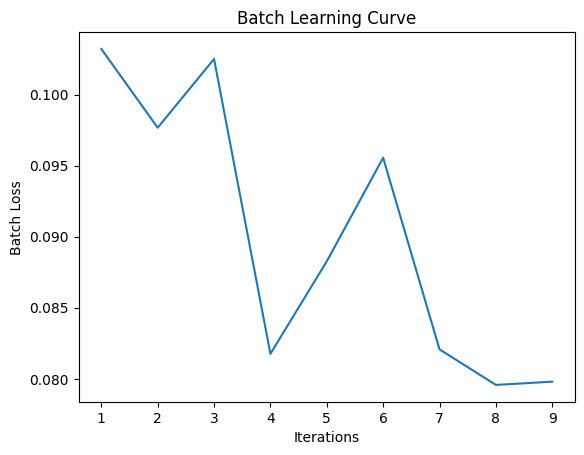

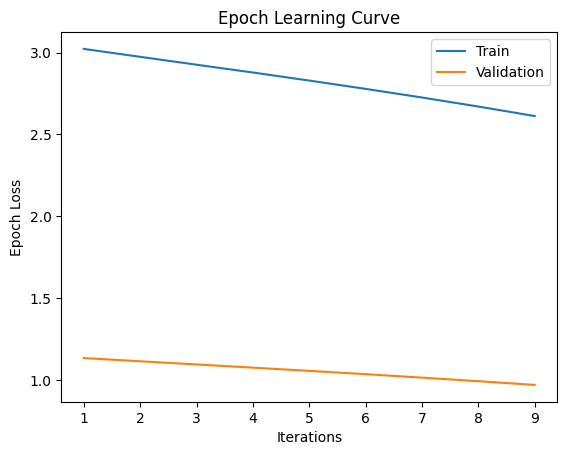

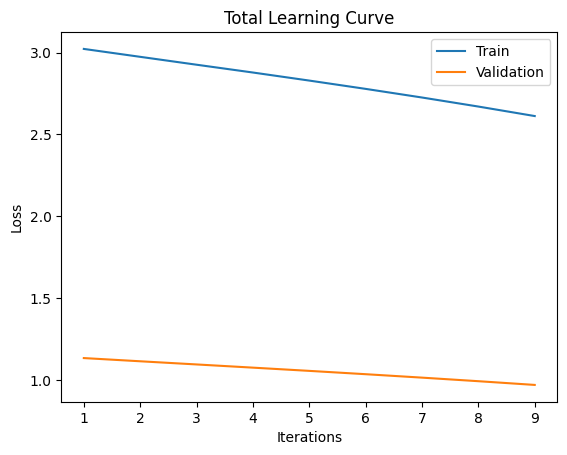

Final Training Loss: 2.612101948261261
Final Validation Loss: 0.9710873901844025
Epoch: 1
Training Loss: 1.919930452108383
Validation Loss: 0.707120057940483


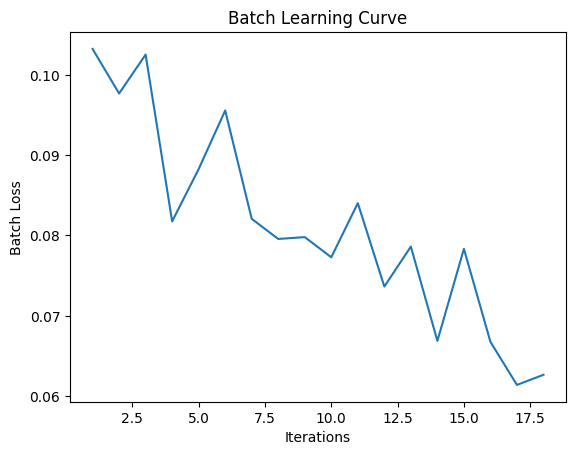

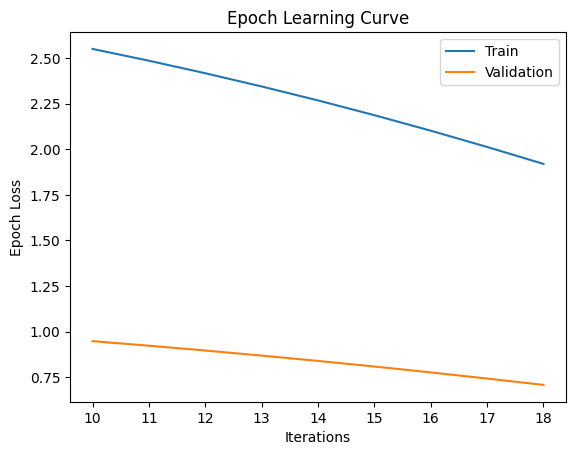

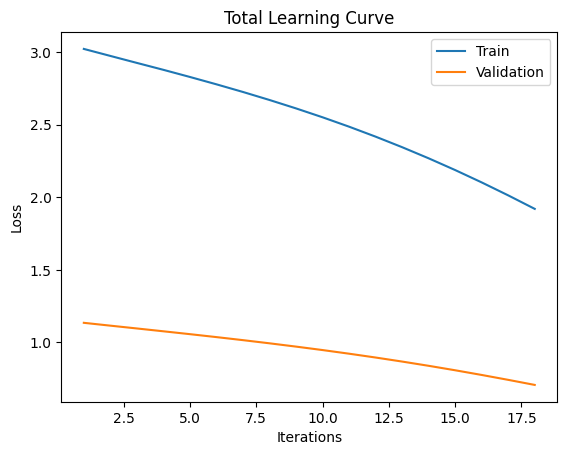

Final Training Loss: 1.919930452108383
Final Validation Loss: 0.707120057940483
Epoch: 2
Training Loss: 1.0307227164506911
Validation Loss: 0.41296131163835526


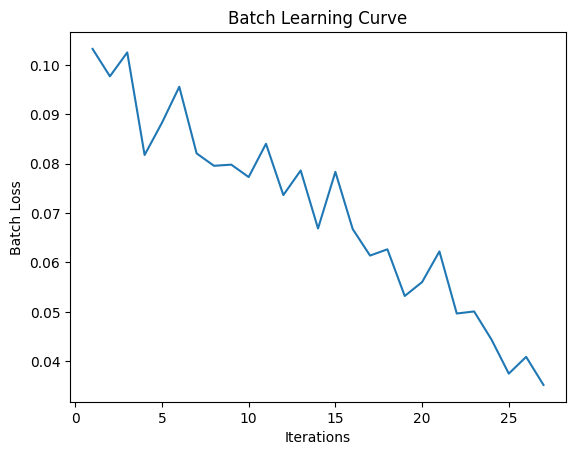

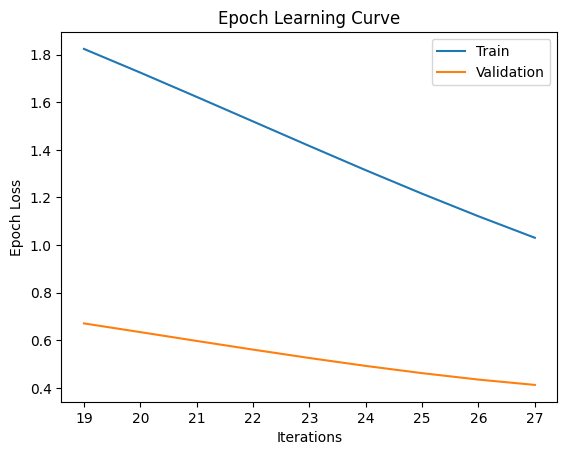

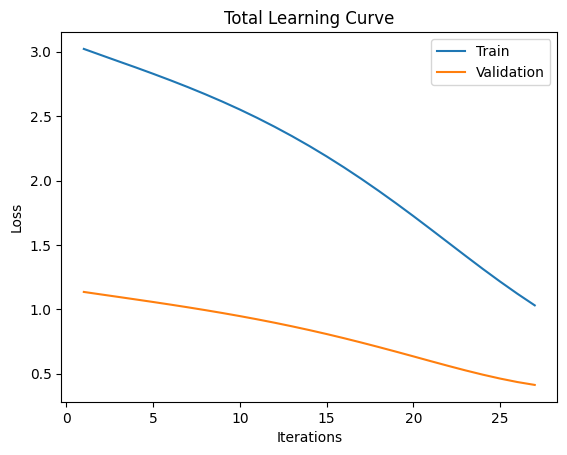

Final Training Loss: 1.0307227164506911
Final Validation Loss: 0.41296131163835526
Epoch: 3
Training Loss: 0.4852244913578033
Validation Loss: 0.45208940505981443


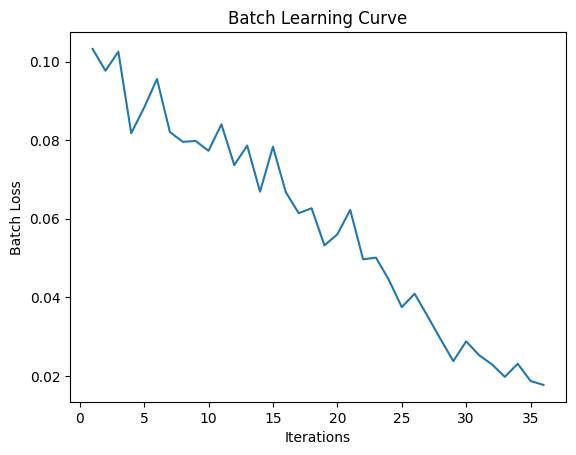

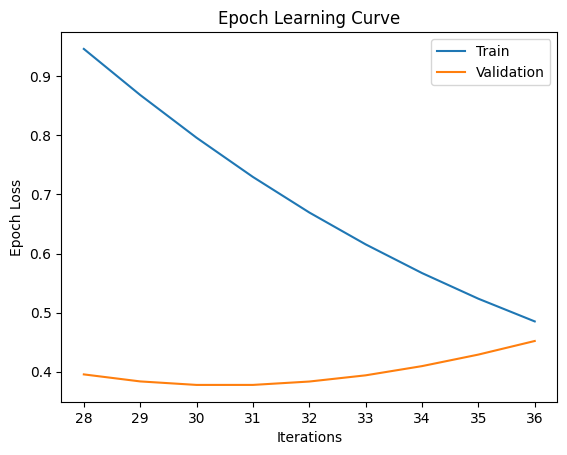

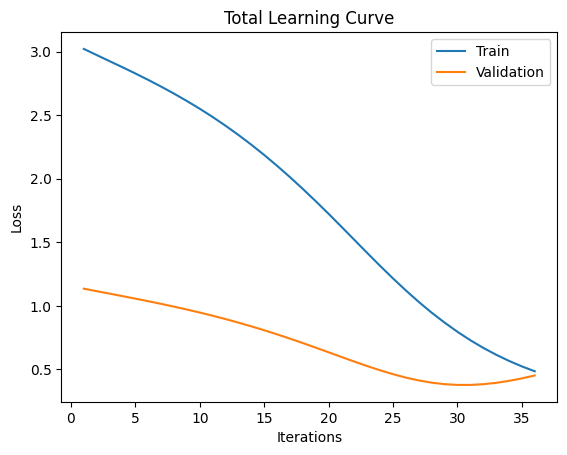

Final Training Loss: 0.4852244913578033
Final Validation Loss: 0.45208940505981443
Epoch: 4
Training Loss: 0.2931822523474693
Validation Loss: 0.6709928676486016


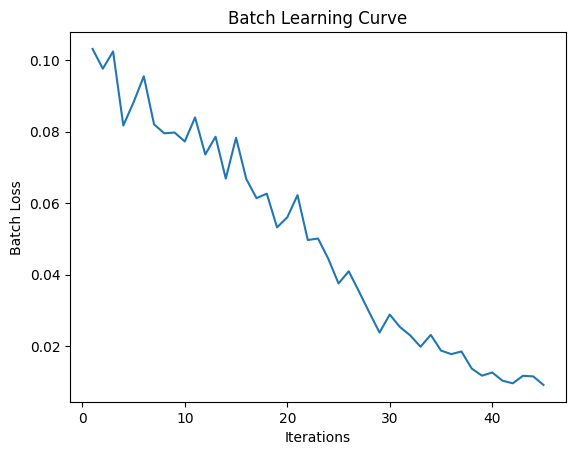

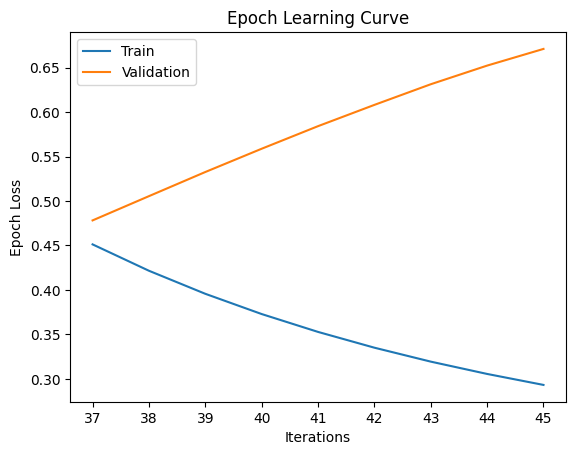

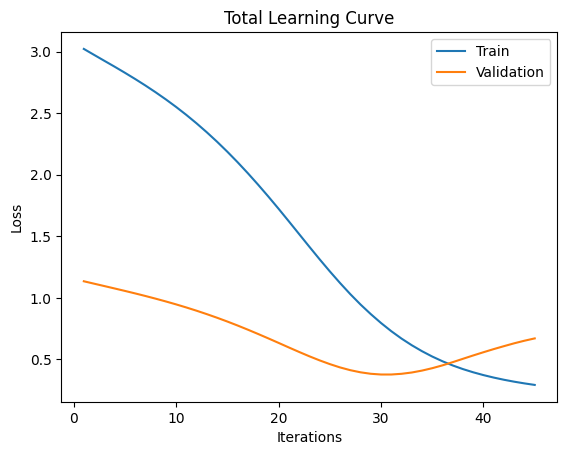

Final Training Loss: 0.2931822523474693
Final Validation Loss: 0.6709928676486016
Epoch: 5
Training Loss: 0.22425999864935875
Validation Loss: 0.7523022204637527


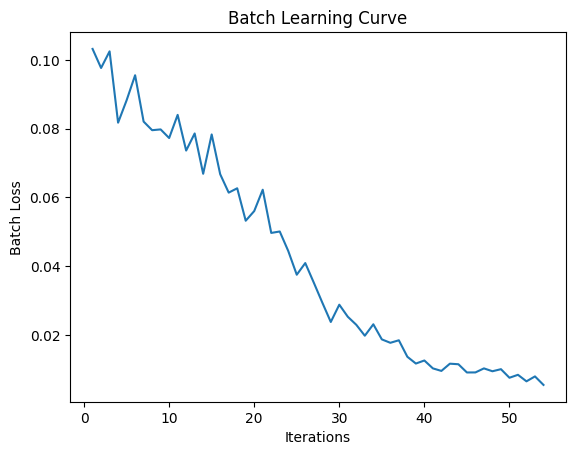

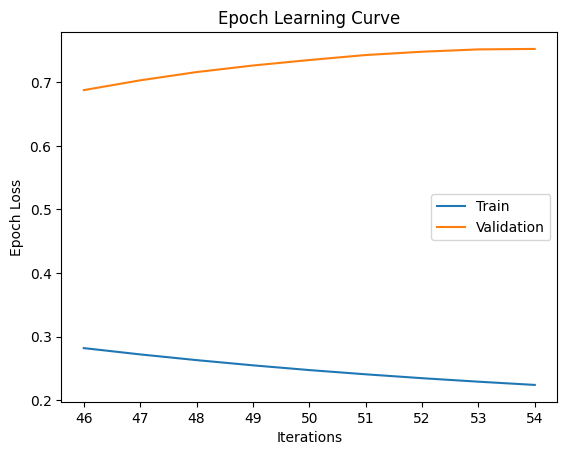

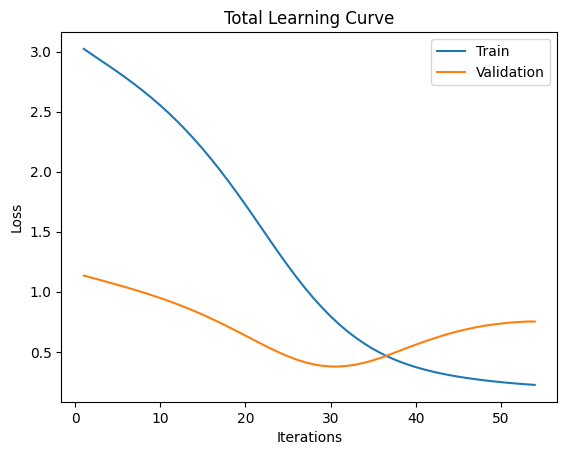

Final Training Loss: 0.22425999864935875
Final Validation Loss: 0.7523022204637527
Epoch: 6
Training Loss: 0.1979546394199133
Validation Loss: 0.7212981663644313


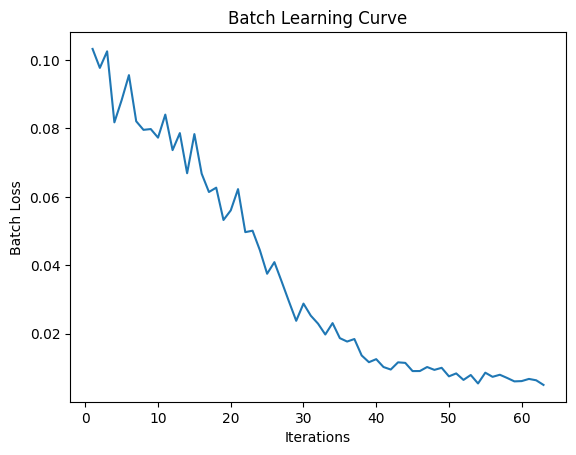

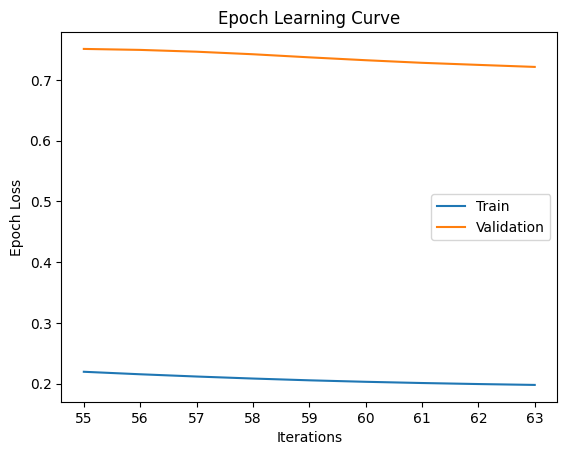

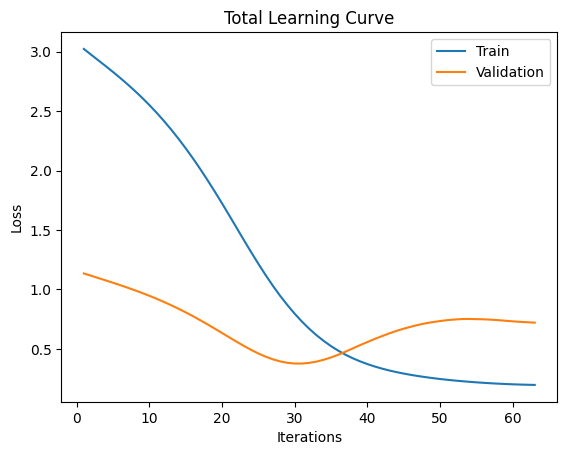

Final Training Loss: 0.1979546394199133
Final Validation Loss: 0.7212981663644313
Epoch: 7
Training Loss: 0.18991024047136307
Validation Loss: 0.703729621320963


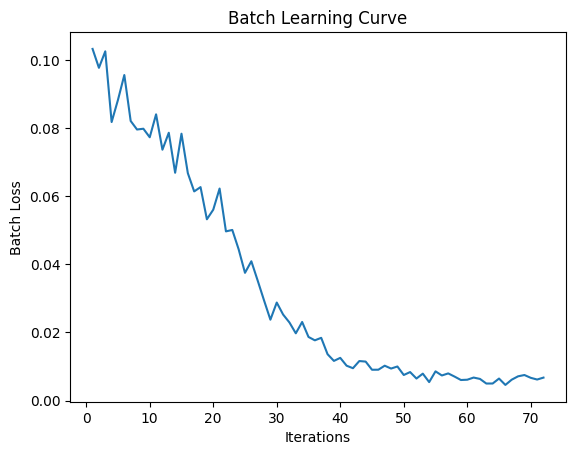

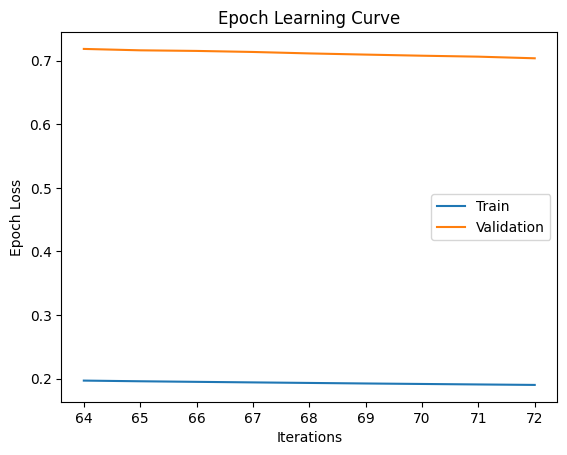

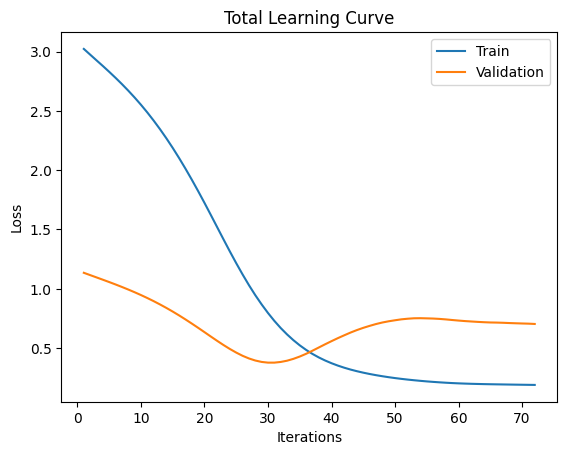

Final Training Loss: 0.18991024047136307
Final Validation Loss: 0.703729621320963
Epoch: 8
Training Loss: 0.18421812169253826
Validation Loss: 0.6902400210499764


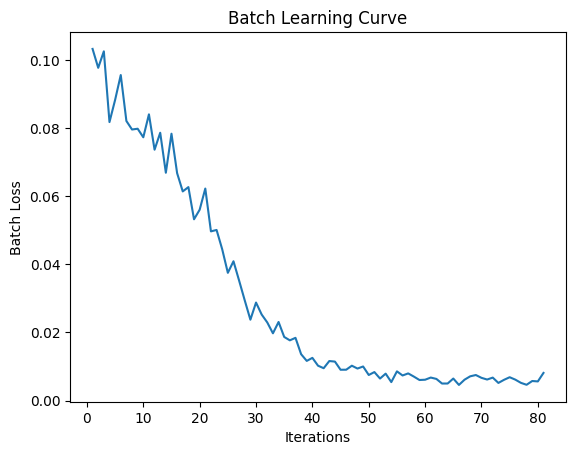

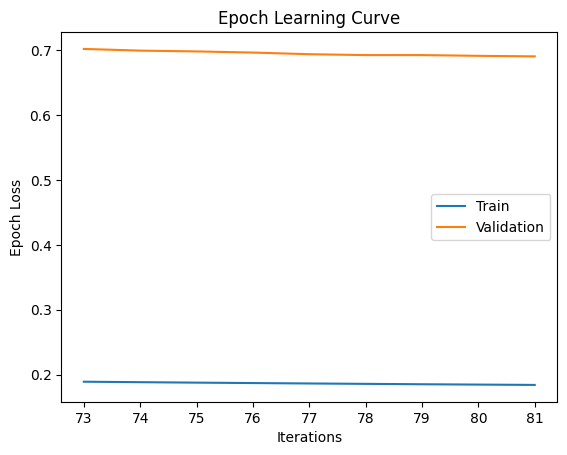

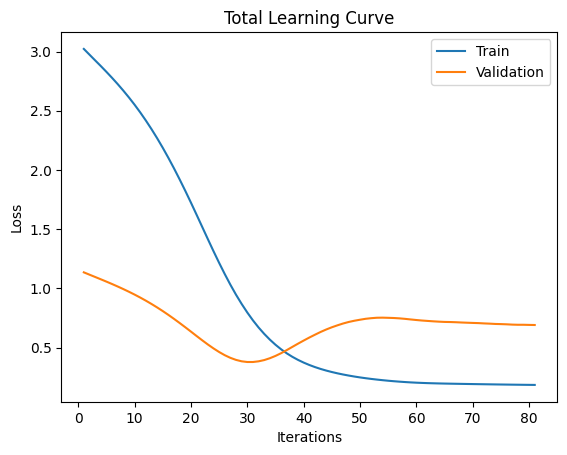

Final Training Loss: 0.18421812169253826
Final Validation Loss: 0.6902400210499764
Epoch: 9
Training Loss: 0.1808894969522953
Validation Loss: 0.6938340730965138


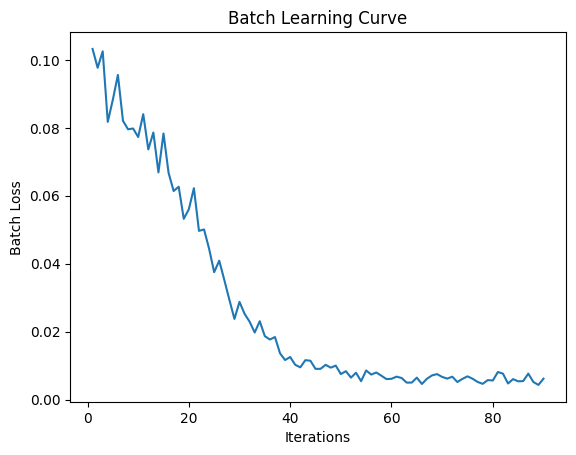

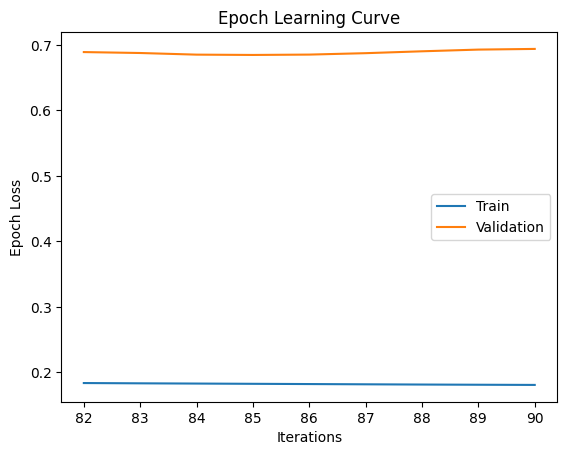

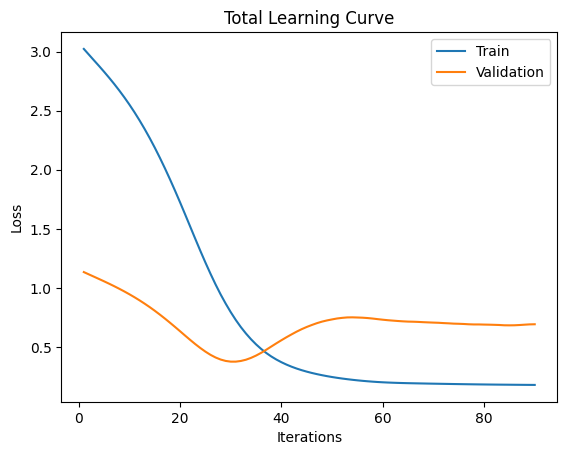

Final Training Loss: 0.1808894969522953
Final Validation Loss: 0.6938340730965138


In [59]:
# Overfit the small tainning set
train(model, small_train_dataset, small_valid_dataset, batch_size=32, checkpoint_path=None)

['LossData84.pkl', 'LossData168.pkl', 'LossData252.pkl', 'LossData336.pkl', 'LossData420.pkl', 'LossData504.pkl', 'LossData588.pkl', 'LossData672.pkl', 'LossData756.pkl', 'LossData840.pkl']
Loaded ckpt/Loss/LossData840.pkl
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,

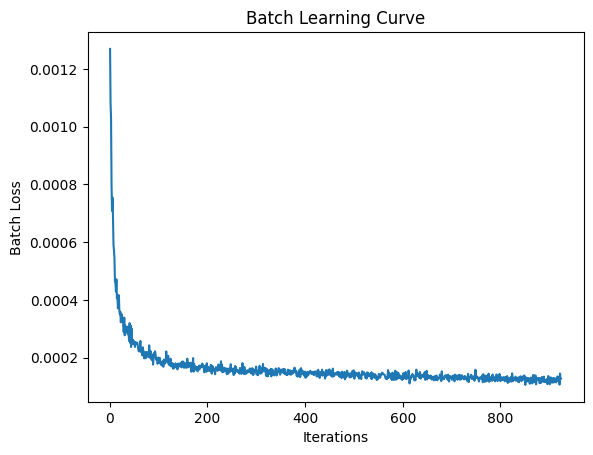

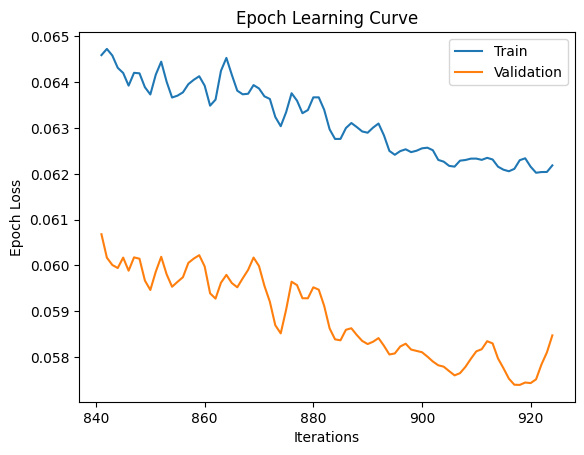

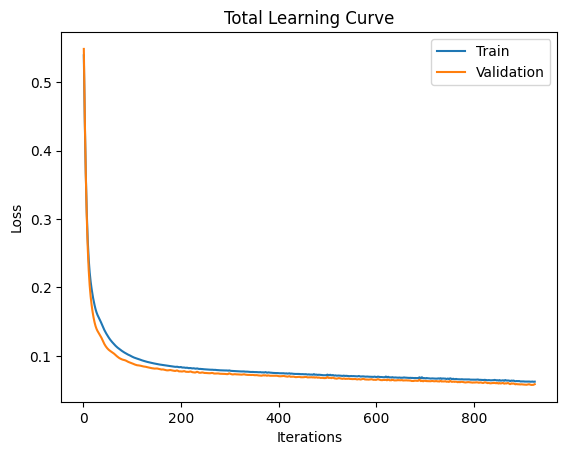

Final Training Loss: 0.06218437583130949
Final Validation Loss: 0.05847467301303849
Epoch: 1
Training Loss: 0.05995782063726117
Validation Loss: 0.05556743728983052
ckpt/Weight/WeightData1008.ckpt
ckpt/Loss/LossData1008.pkl


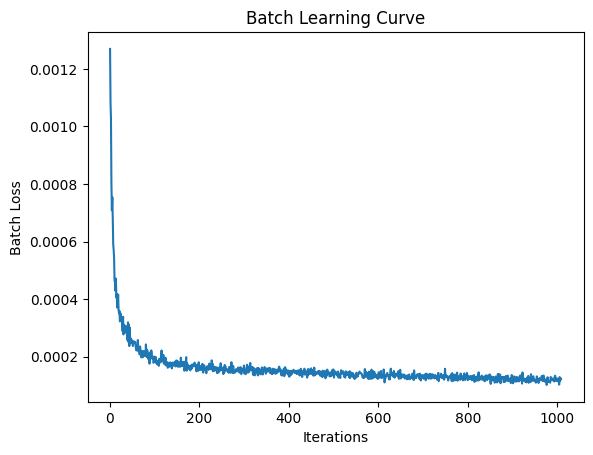

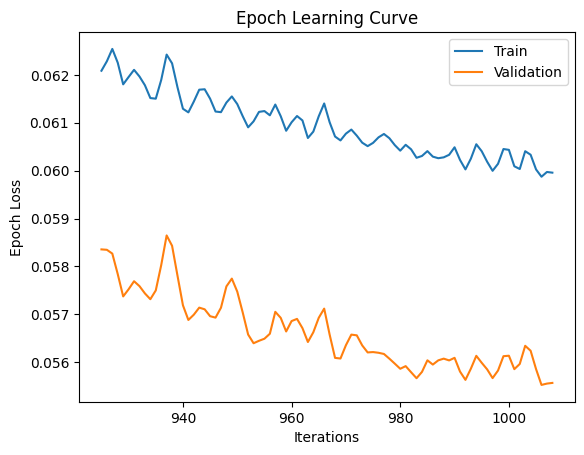

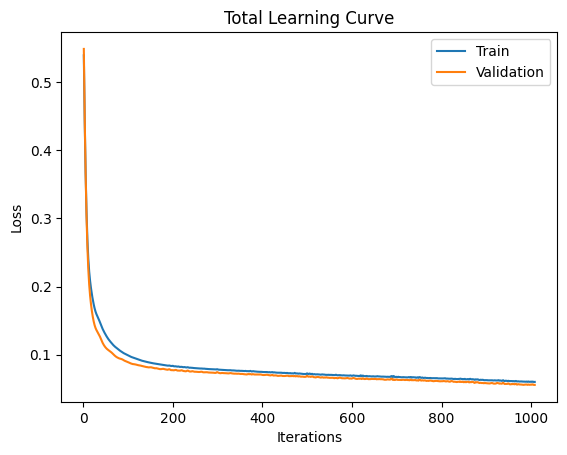

Final Training Loss: 0.05995782063726117
Final Validation Loss: 0.05556743728983052
Epoch: 2
Training Loss: 0.05838977212415022
Validation Loss: 0.05417188021409161
ckpt/Weight/WeightData1092.ckpt
ckpt/Loss/LossData1092.pkl


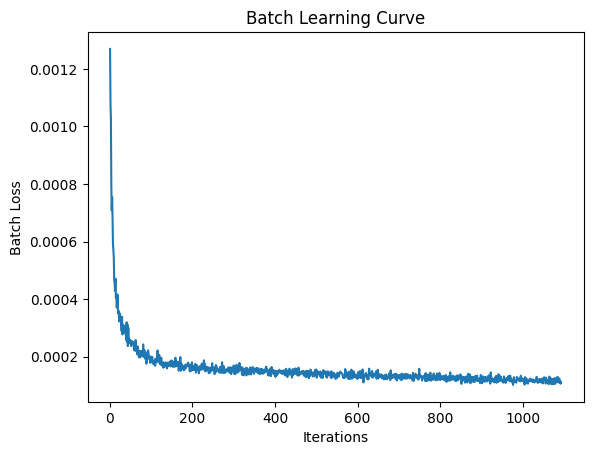

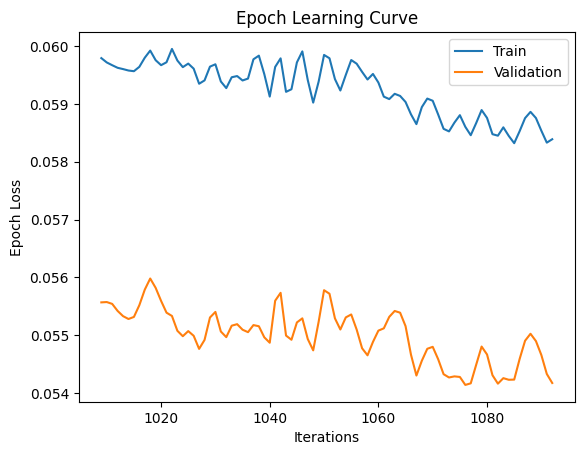

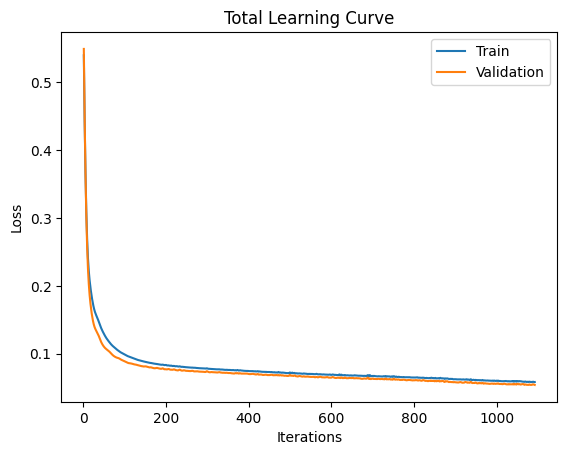

Final Training Loss: 0.05838977212415022
Final Validation Loss: 0.05417188021409161
Epoch: 3
Training Loss: 0.05745178323019953
Validation Loss: 0.05310260937275255
ckpt/Weight/WeightData1176.ckpt
ckpt/Loss/LossData1176.pkl


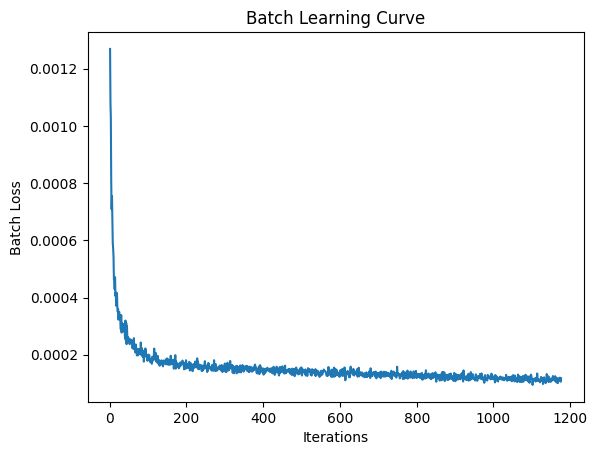

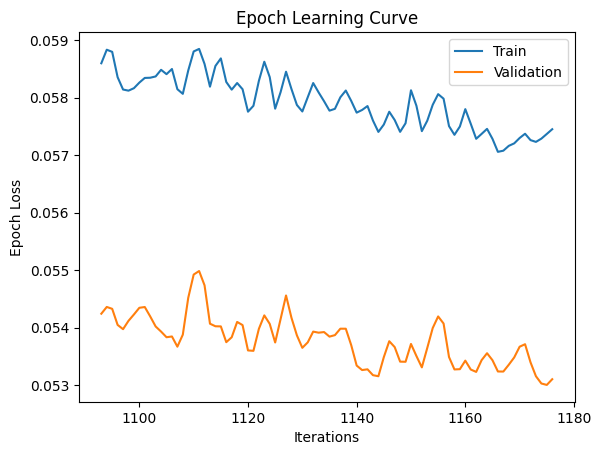

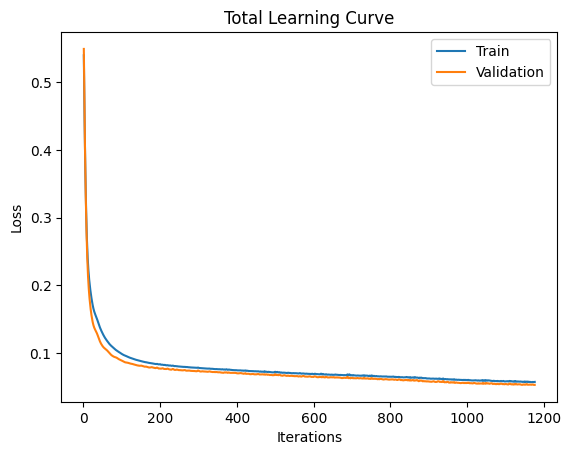

Final Training Loss: 0.05745178323019953
Final Validation Loss: 0.05310260937275255
Epoch: 4
Training Loss: 0.056040044808212446
Validation Loss: 0.05245774063993903
ckpt/Weight/WeightData1260.ckpt
ckpt/Loss/LossData1260.pkl


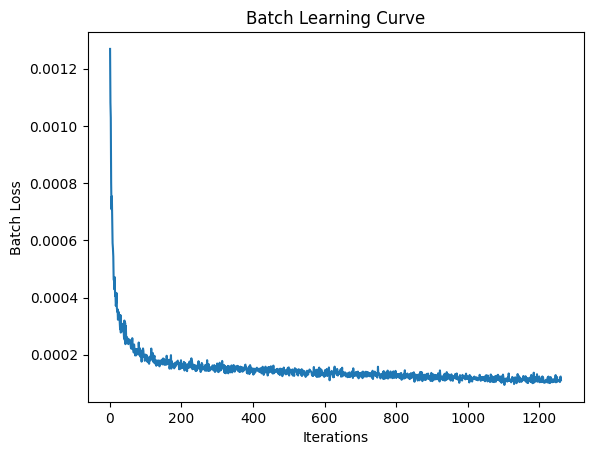

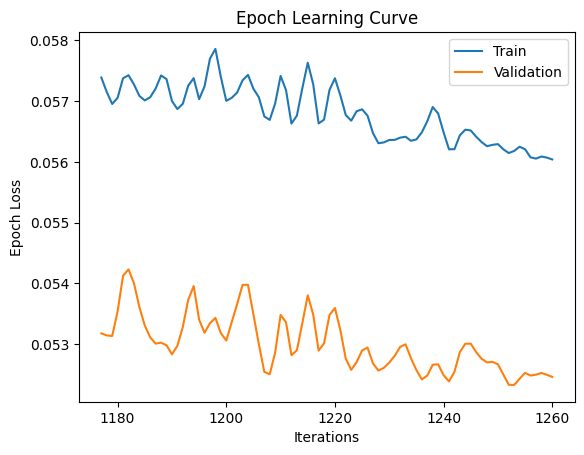

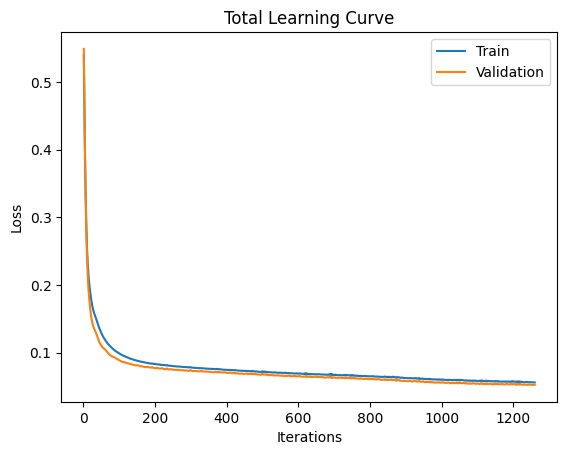

Final Training Loss: 0.056040044808212446
Final Validation Loss: 0.05245774063993903
Epoch: 5
Training Loss: 0.05529463797369424
Validation Loss: 0.0517370468005538
ckpt/Weight/WeightData1344.ckpt
ckpt/Loss/LossData1344.pkl


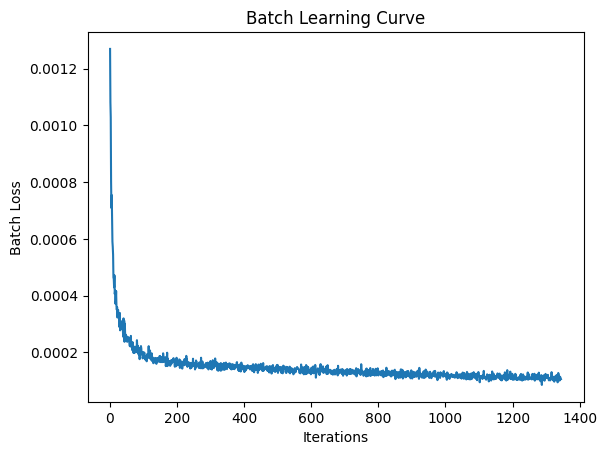

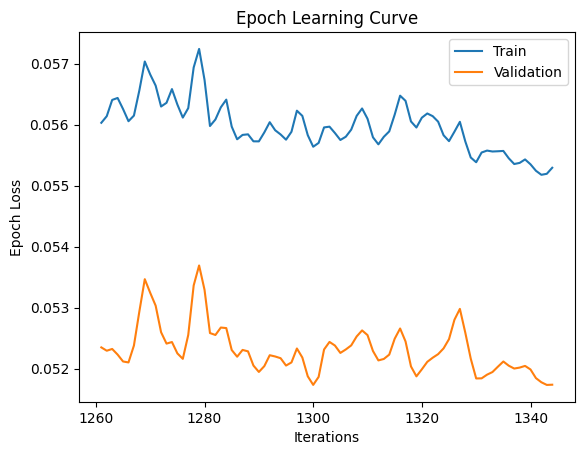

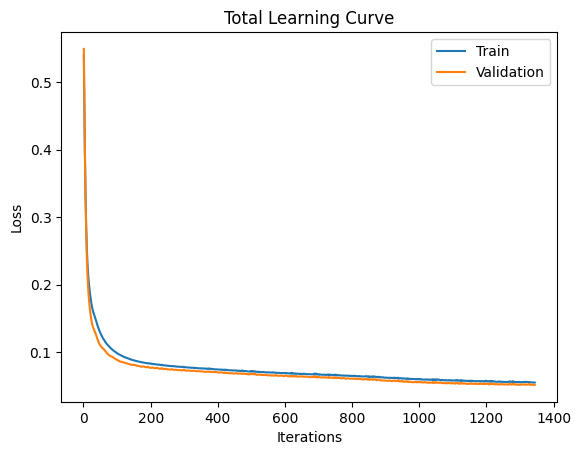

Final Training Loss: 0.05529463797369424
Final Validation Loss: 0.0517370468005538
Epoch: 6
Training Loss: 0.0554531764896477
Validation Loss: 0.052123354035703576
ckpt/Weight/WeightData1428.ckpt
ckpt/Loss/LossData1428.pkl


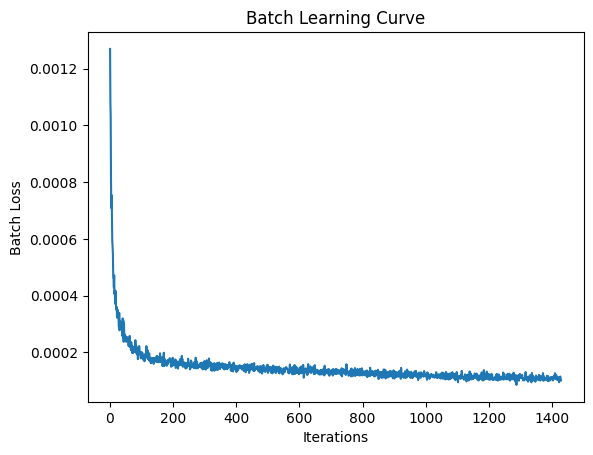

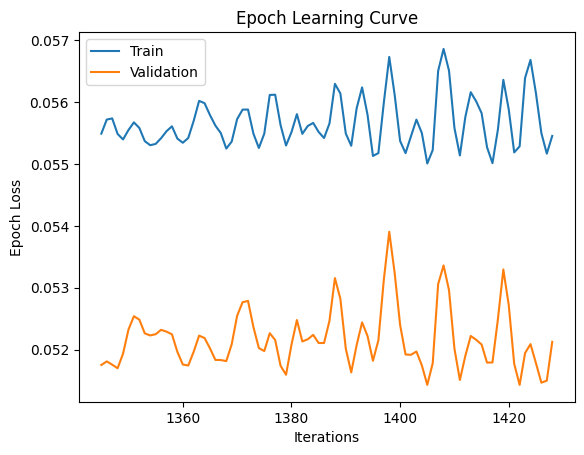

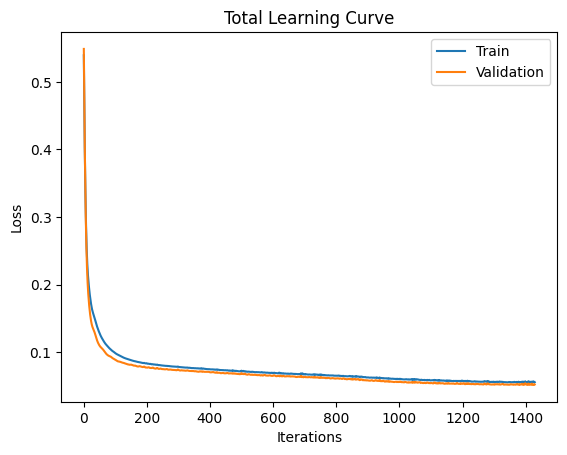

Final Training Loss: 0.0554531764896477
Final Validation Loss: 0.052123354035703576
Epoch: 7
Training Loss: 0.05502136362826123
Validation Loss: 0.05210427687886883
ckpt/Weight/WeightData1512.ckpt
ckpt/Loss/LossData1512.pkl


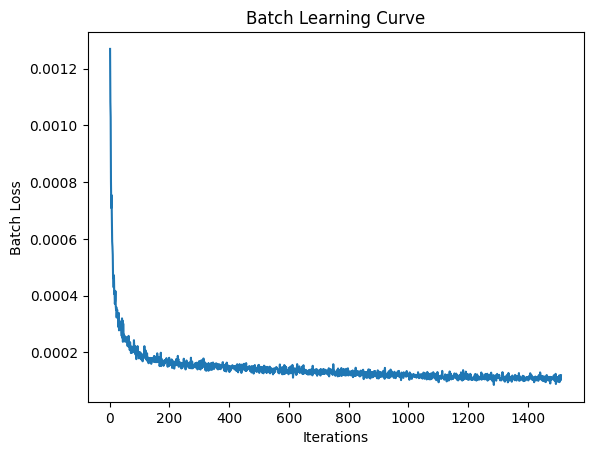

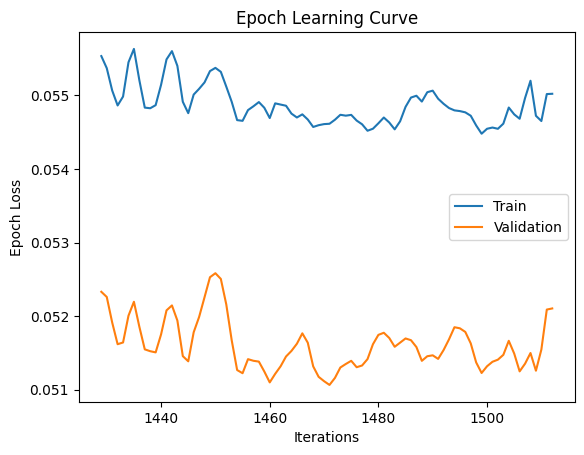

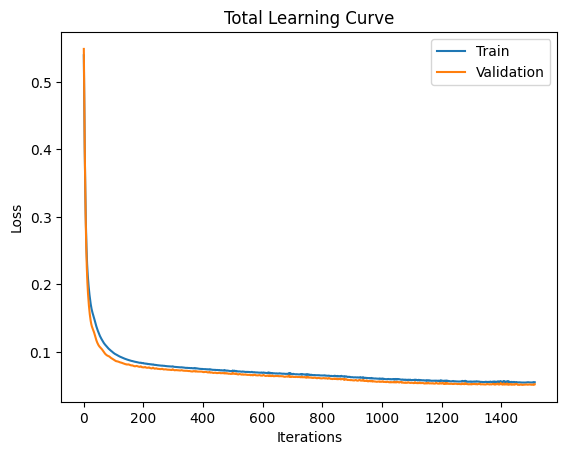

Final Training Loss: 0.05502136362826123
Final Validation Loss: 0.05210427687886883
Epoch: 8
Training Loss: 0.05434341080048505
Validation Loss: 0.051099478102782196
ckpt/Weight/WeightData1596.ckpt
ckpt/Loss/LossData1596.pkl


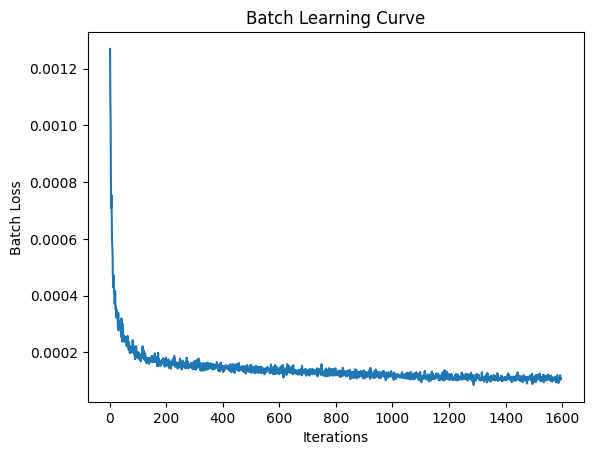

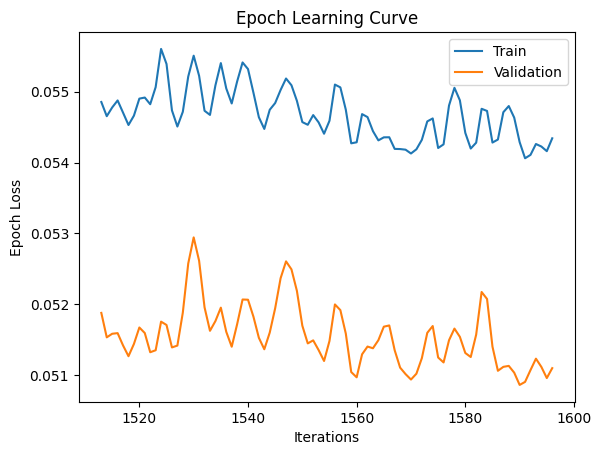

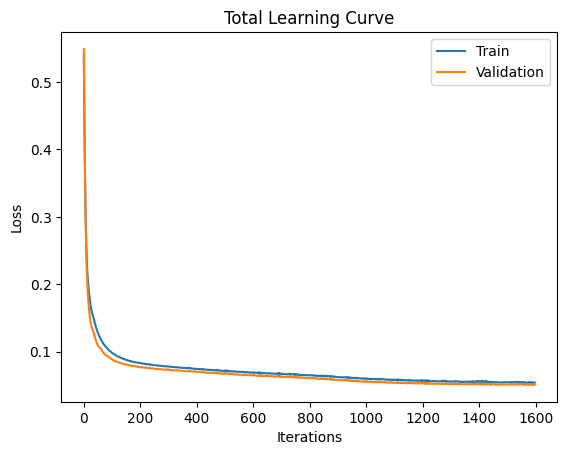

Final Training Loss: 0.05434341080048505
Final Validation Loss: 0.051099478102782196
Epoch: 9
Training Loss: 0.05375679998713381
Validation Loss: 0.051005895249545574
ckpt/Weight/WeightData1680.ckpt
ckpt/Loss/LossData1680.pkl


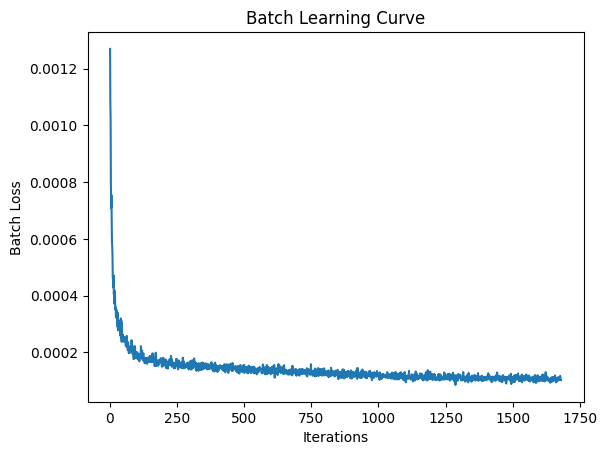

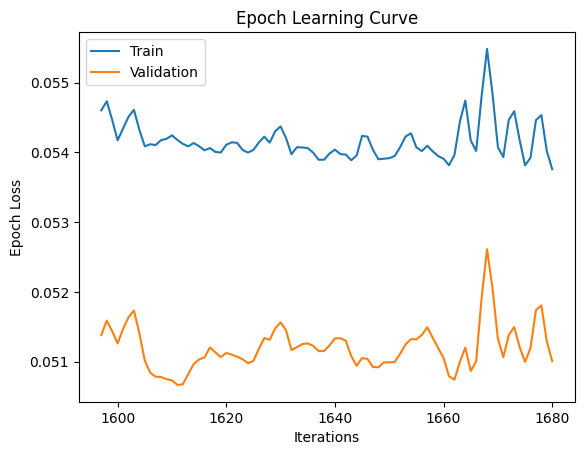

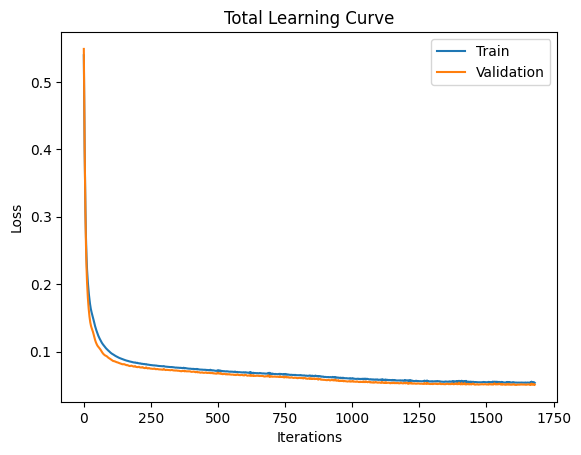

Final Training Loss: 0.05375679998713381
Final Validation Loss: 0.051005895249545574


In [60]:
#start train model
train(model,train_dataset, valid_dataset, weight_decay=0.0001, checkpoint_path=checkpoint_path)

## 7. Results

In [61]:
# Load Weights
model = GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
model = model.to(device)

weight_path = checkpoint_path + 'Weight/'
files = os.listdir(weight_path)

if len(files) != 0:
    sorted_files = sorted(files, key=extract_number)
    selected_file = sorted_files[-1]
    weight_path += selected_file

    model.load_state_dict(torch.load(weight_path))  #load the weight
    print(f'Loaded: {weight_path}')

Loaded: ckpt/Weight/WeightData1680.ckpt


In [62]:
def graph_pred(model, data, batch_size, sample_mean, sample_std):
    predictions = []
    targets = []

    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)
    model.eval()

    sample_mean_tensor = torch.tensor(sample_mean, device=device)
    sample_std_tensor = torch.tensor(sample_std, device=device)

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            output = output * sample_std_tensor + sample_mean_tensor
            target = target * sample_std_tensor + sample_mean_tensor

            predictions += output.view(-1).tolist()
            targets += target.view(-1).tolist()

    return predictions, targets

0.06671380251646042


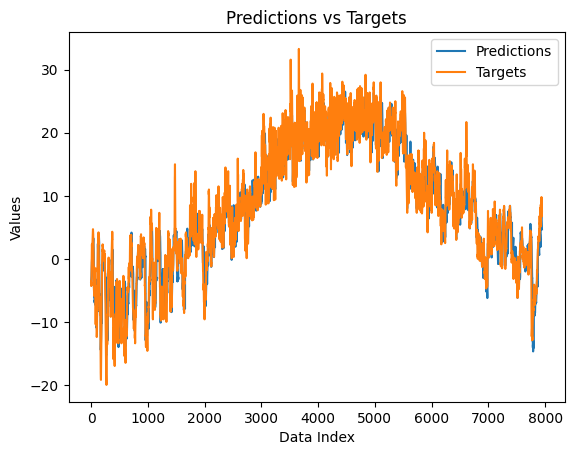

In [63]:
# MSE for Test Set
MSE = get_loss(model=model, data=oneday_test_dataset, criterion=nn.MSELoss(), batch_size=512)
print(MSE)

predictions, targets = graph_pred(model=model, data=oneday_test_dataset, batch_size=512, sample_mean=temp_mean, sample_std=temp_std)

# Create a range for the x-axis based on the length of the predictions or targets
x = range(len(predictions))

# Plot the predictions and targets on the same graph
plt.plot(x, predictions, label='Predictions')
plt.plot(x, targets, label='Targets')

# Add labels, title, and legend
plt.xlabel('Data Index')
plt.ylabel('Values')
plt.title('Predictions vs Targets')
plt.legend()

# Display the plot
plt.show()

In [64]:
import plotly.graph_objs as go
import plotly.offline as pyo

layout = dict(
    title='Actual Value vs Prediction of Temperature',
    xaxis=dict(title="Hours", ticklen=5, zeroline=False),
    yaxis=dict(title="Temperature", ticklen=5, zeroline=False),
)

target = go.Scatter(
    y=targets,
    mode="lines",
    name="target",
    marker=dict(),
    line=dict(color="rgba(0,0,0, 0.3)"),
)

prediction = go.Scatter(
    y=predictions,
    mode="lines",
    line={"dash": "dot"},
    name='predictions',
    marker=dict(),
    opacity=0.8,
)

fig = dict(data=[target, prediction], layout=layout)
pyo.iplot(fig)